This is a python implementation of the reduced complexity ice-age model presented in Talento & Ganopolski (2021). It is based on the description in the paper and accompanying code available at https://osf.io/kb76g/, where you will also find the orbital forcing used as an input to the model and palaeo ice-volume (sea-level stack) records to which the model was calibrated.

We were unable to replicate the results reported by Talento & Ganopolski (2021) using the provided model parameters. Consequently, we recalibrated the model using a Markov Chain Monte Carlo (MCMC) approach (code not included here). The plots below illustrate a comparison between the outcomes using the original model parameters and those obtained through our recalibration.

Finally, this document also shows the effect of adding additive noise to the ice-volume to represent unresolved processes. The ice volume equation from the original paper is thus changed accordingly: 

$$
\begin{equation}
\mathrm{d} v=\left(\frac{b_1 v-b_2 v^{3 / 2}-b_3(f-\bar{f})-b_4 \log \left(\mathrm{CO}_2\right)}{1-b_5 M_{\mathrm{v}}}+b_6\right) \mathrm{d} t+\sigma d W .
\end{equation}
$$

where $\mathrm{d}W$ is a Wiener process implemented as Gaussian noise with mean 0 and standard deviation $\sqrt{\Delta t} = \sqrt{1} = 1$, and $\sigma=0.001$ is a scaling factor, chosen such that the stochastic ensemble still remains characterised by the 100 kyr periodicity. 

Talento, S., & Ganopolski, A. (2021). Reduced-complexity model for the impact of anthropogenic CO 2 emissions on future glacial cycles. Earth System Dynamics, 12(4), 1275-1293.

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300

In [2]:
class Talento():

    def __init__(self, params, noise=0, seed=0, n_time_steps=1000):

        # orbital forcing used in model
        smx_p = loadmat('smx_p_2000kyr.mat')['smx_p'][0]
        smx_o = loadmat('smx_o_2000kyr.mat')['smx_o'][0]
        val = 1.04
        self.f = smx_p + val * (smx_o - np.mean(smx_o))
        self.f_mean = np.mean(self.f)

        # init conditions
        v_0 = 0.0
        CO2_0 = 300.0
        T_0 = 0.0

        # init arrays
        self.N_time_steps = n_time_steps
        self.t_range = np.arange(-1000, self.N_time_steps - 1000)
        self.v = np.full(self.N_time_steps, v_0)
        self.CO2 = np.full(self.N_time_steps, CO2_0)
        self.T = np.full(self.N_time_steps, T_0)

        # fixed params
        self.d1 = -3
        self.d2 = 5.56
        self.c4 = 278.

        # other params
        self.par = params
        self.tau = 30 # memory term
        self.dt = 1  # time step

        # noise
        self.sigma = noise       # noise strength
        self.sigma_start = 200   # in time steps
        self.sigma_end = 1000    # in time steps
        self.additive_noise = np.random.default_rng(seed=seed).normal(0, np.sqrt(self.dt), self.N_time_steps) * self.sigma  # gaussian noise with mean 0 and std=sqrt(dt)


    def update(self,t):     
        par = self.par

        # Equation: T
        self.T[t] = self.d1 * self.v[t-1] + self.d2 * np.log(self.CO2[t-1] / self.c4);
        
        # Equation: CO2
        dvdt = (self.v[t-1] - self.v[t-2])/self.dt
        self.CO2[t] = par["c1"] * self.T[t] + par["c2"] * self.v[t-1] + par["c3"] * min(dvdt, 0) + self.c4
        self.CO2[t] = max(self.CO2[t], 150) # constraint (13), should be 150ppm

        # Equation: ice-volume
        delta = 1 if dvdt < 0 else 0
        M_v = delta * np.trapz(self.v[t-1-self.tau:t-1]) / self.tau  # memory term
        dvdt = (par["b1"] * self.v[t-1] - par["b2"] * self.v[t-1]**(3/2) - par["b3"] * (self.f[t-1] - self.f_mean) - par["b4"] * np.log(self.CO2[t-1])) / (1 - par["b5"] * M_v) + par["b6"]
        
        # Additive ice volume noise
        if self.sigma > 0 and t > self.sigma_start and t < self.sigma_end:
            dvdt += self.additive_noise[t]  # noise term according to Euler-Maruyama method

        # compute v
        self.v[t] =  self.v[t-1] + dvdt * self.dt

        # Mid-brunhes ice cover constraint
        if self.t_range[t] < -410: 
            self.v[t] = max(self.v[t], 0.05)  # constriant (12) 
        else:
            self.v[t] = max(self.v[t], 0.0)  # constriant (11)
    
    
    def run(self):
        # run simulation
        for t in range(self.tau, self.N_time_steps):
            self.update(t)
        return self



In [3]:
# tuned params
our_par = {'b1': 0.21225019974916653,
        'b2': 0.2836925345028339,
        'b3': 0.0008174423131295259,
        'b4': 0.095,
        'b5': 0.18964641973723284,
        'b6': 0.5261626610099003,
        'c1': 17.824476083652947,
        'c2': -24.49497200960442,
        'c3': -47.76302777426819}

talento_par = {'b1': 0.22,
        'b2': 0.29,
        'b3': 0.0008,
        'b4': 0.095,
        'b5': 0.18,
        'b6': 0.53,
        'c1': 17.28,
        'c2': -31.95,
        'c3': -120.0}

m = Talento(our_par, 0).run()
m_talento = Talento(talento_par, 0).run()

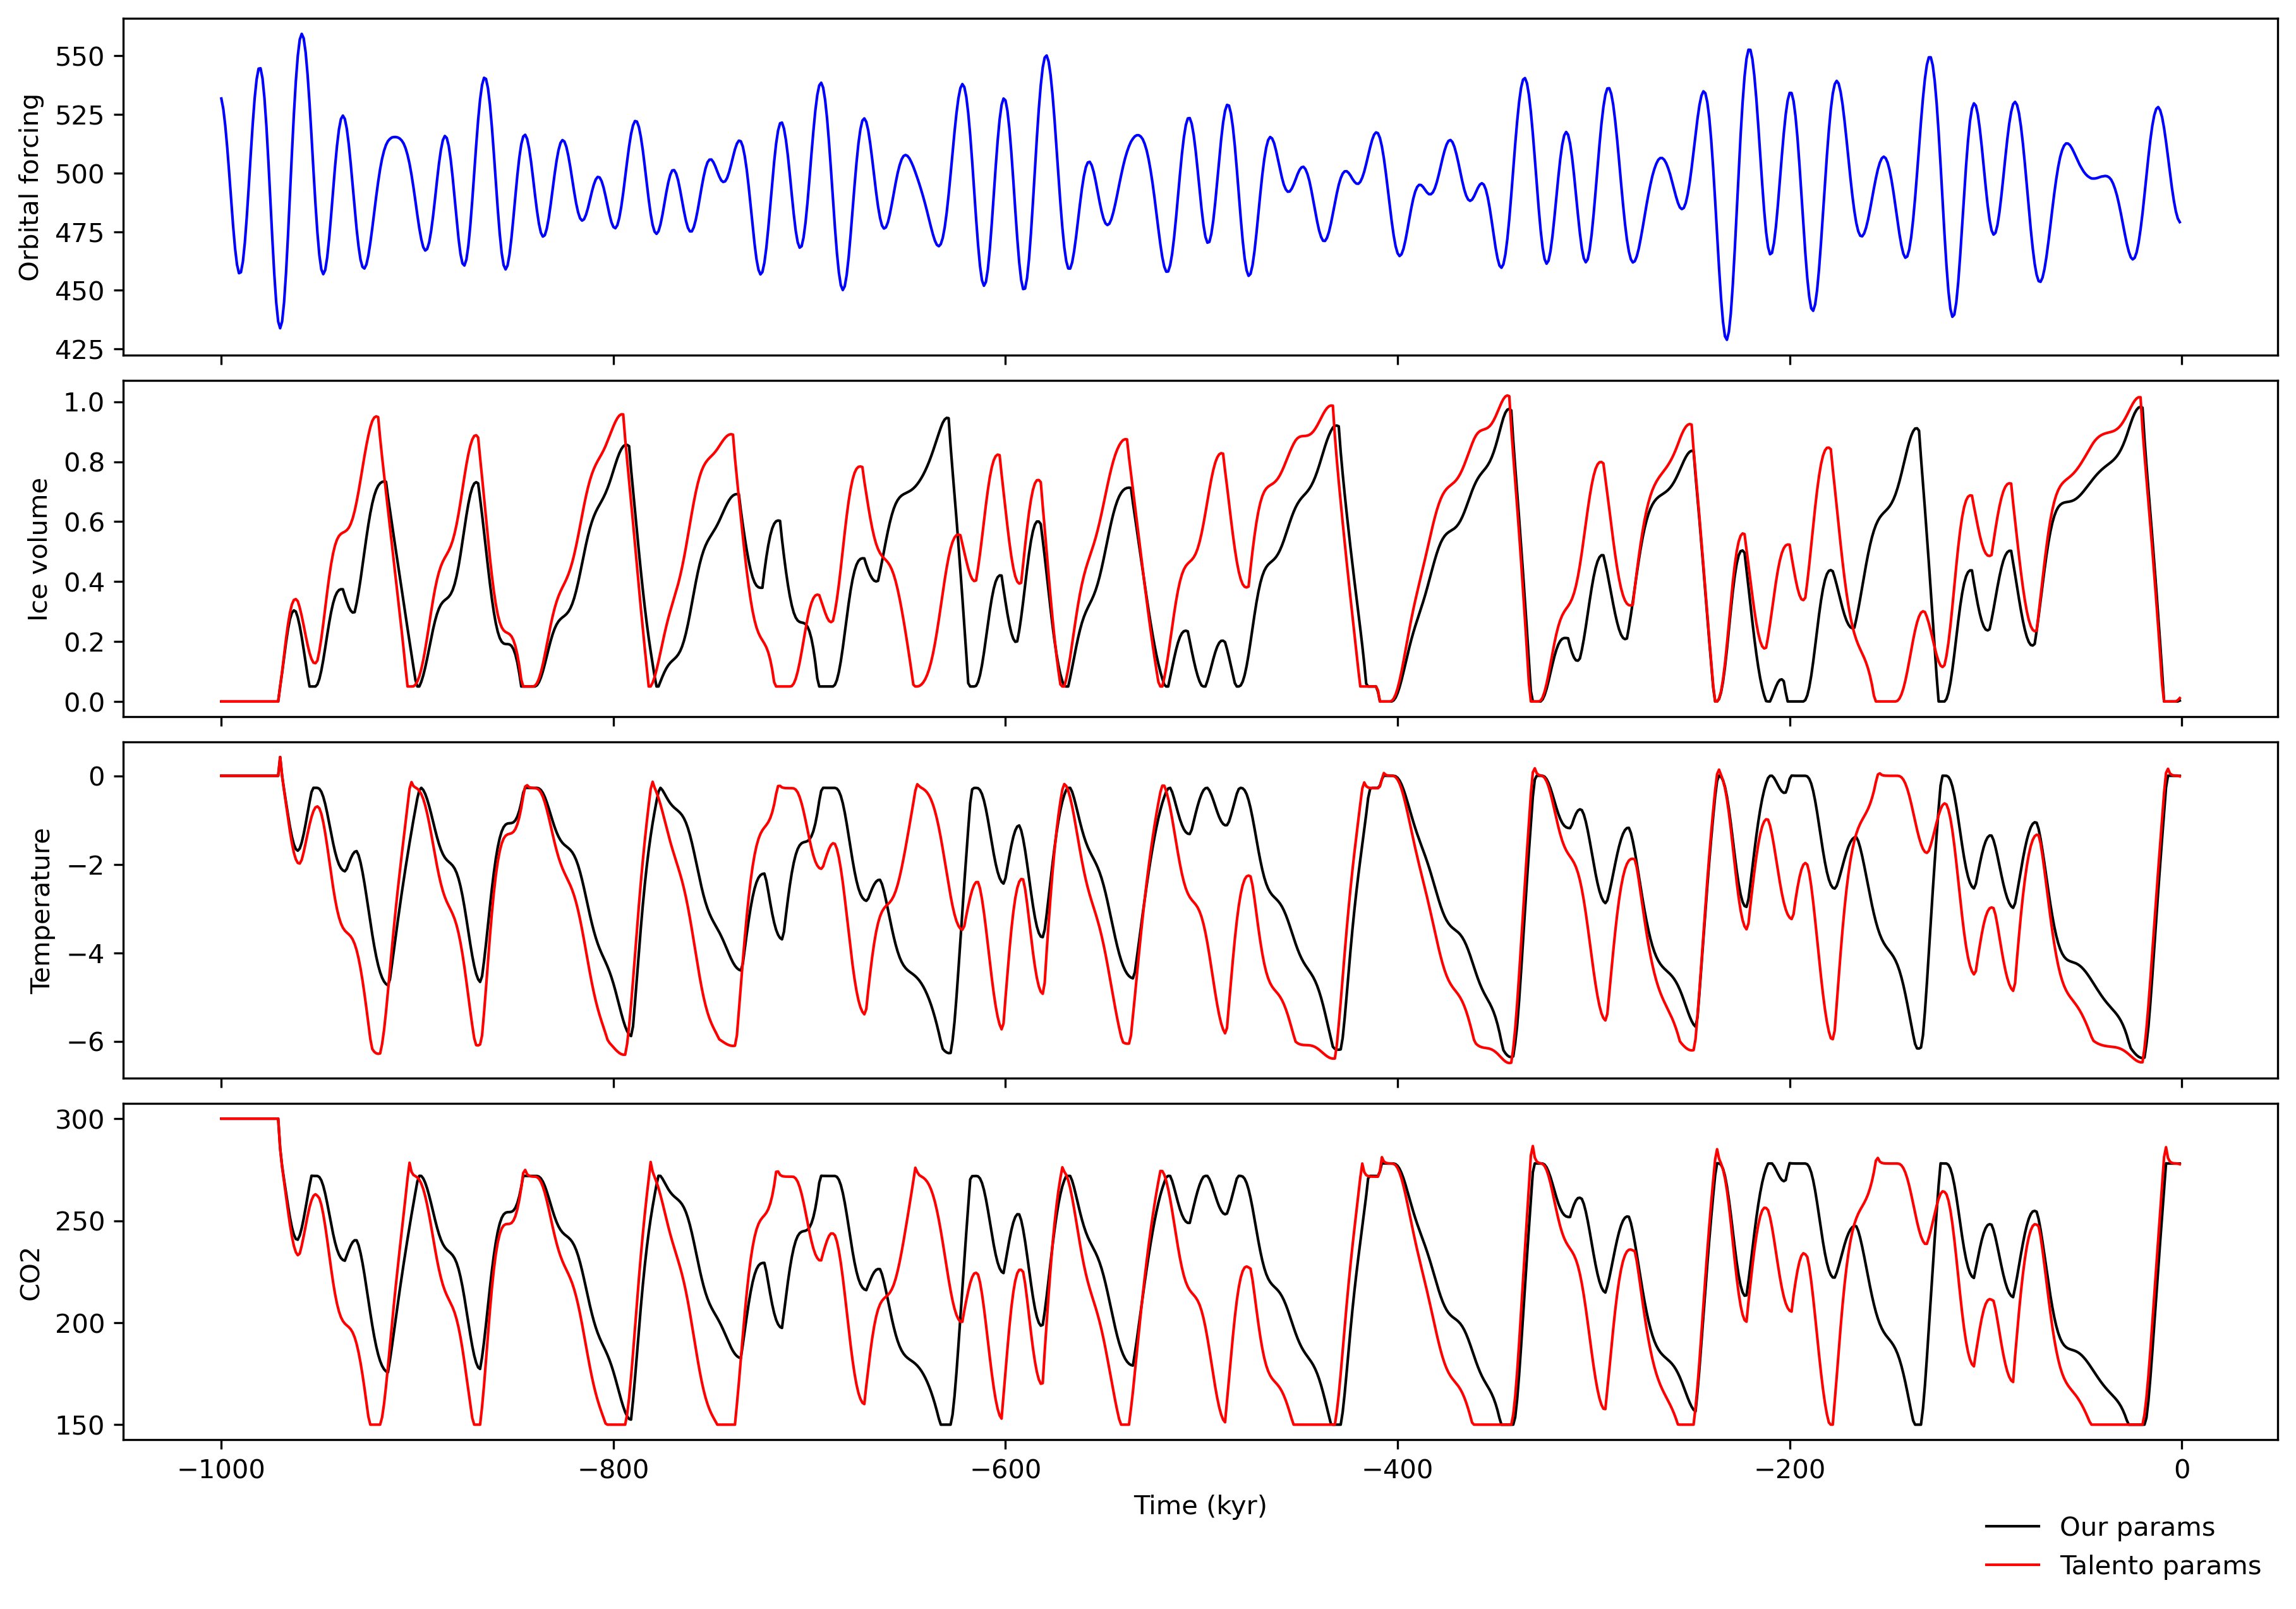

In [4]:
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True, layout="constrained")
# plt.subplots_adjust(hspace=0.075)

# our params
axs[0].plot(m.t_range, m.f[:1000], "blue", lw=1)
axs[1].plot(m.t_range, m.v, "k", lw=1)
axs[2].plot(m.t_range, m.T, "k", lw=1)
axs[3].plot(m.t_range, m.CO2, "k", lw=1, label="Our params")

# talento params
axs[1].plot(m_talento.t_range, m_talento.v, "r", lw=1)
axs[2].plot(m_talento.t_range, m_talento.T, "r", lw=1)
axs[3].plot(m_talento.t_range, m_talento.CO2, "r", lw=1, label="Talento params")
fig.legend(loc="lower right", framealpha=0, bbox_to_anchor=(1, -0.05))

axs[0].set_ylabel('Orbital forcing')
axs[1].set_ylabel('Ice volume')
axs[2].set_ylabel('Temperature')
axs[3].set_ylabel('CO2')
axs[3].set_xlabel('Time (kyr)');

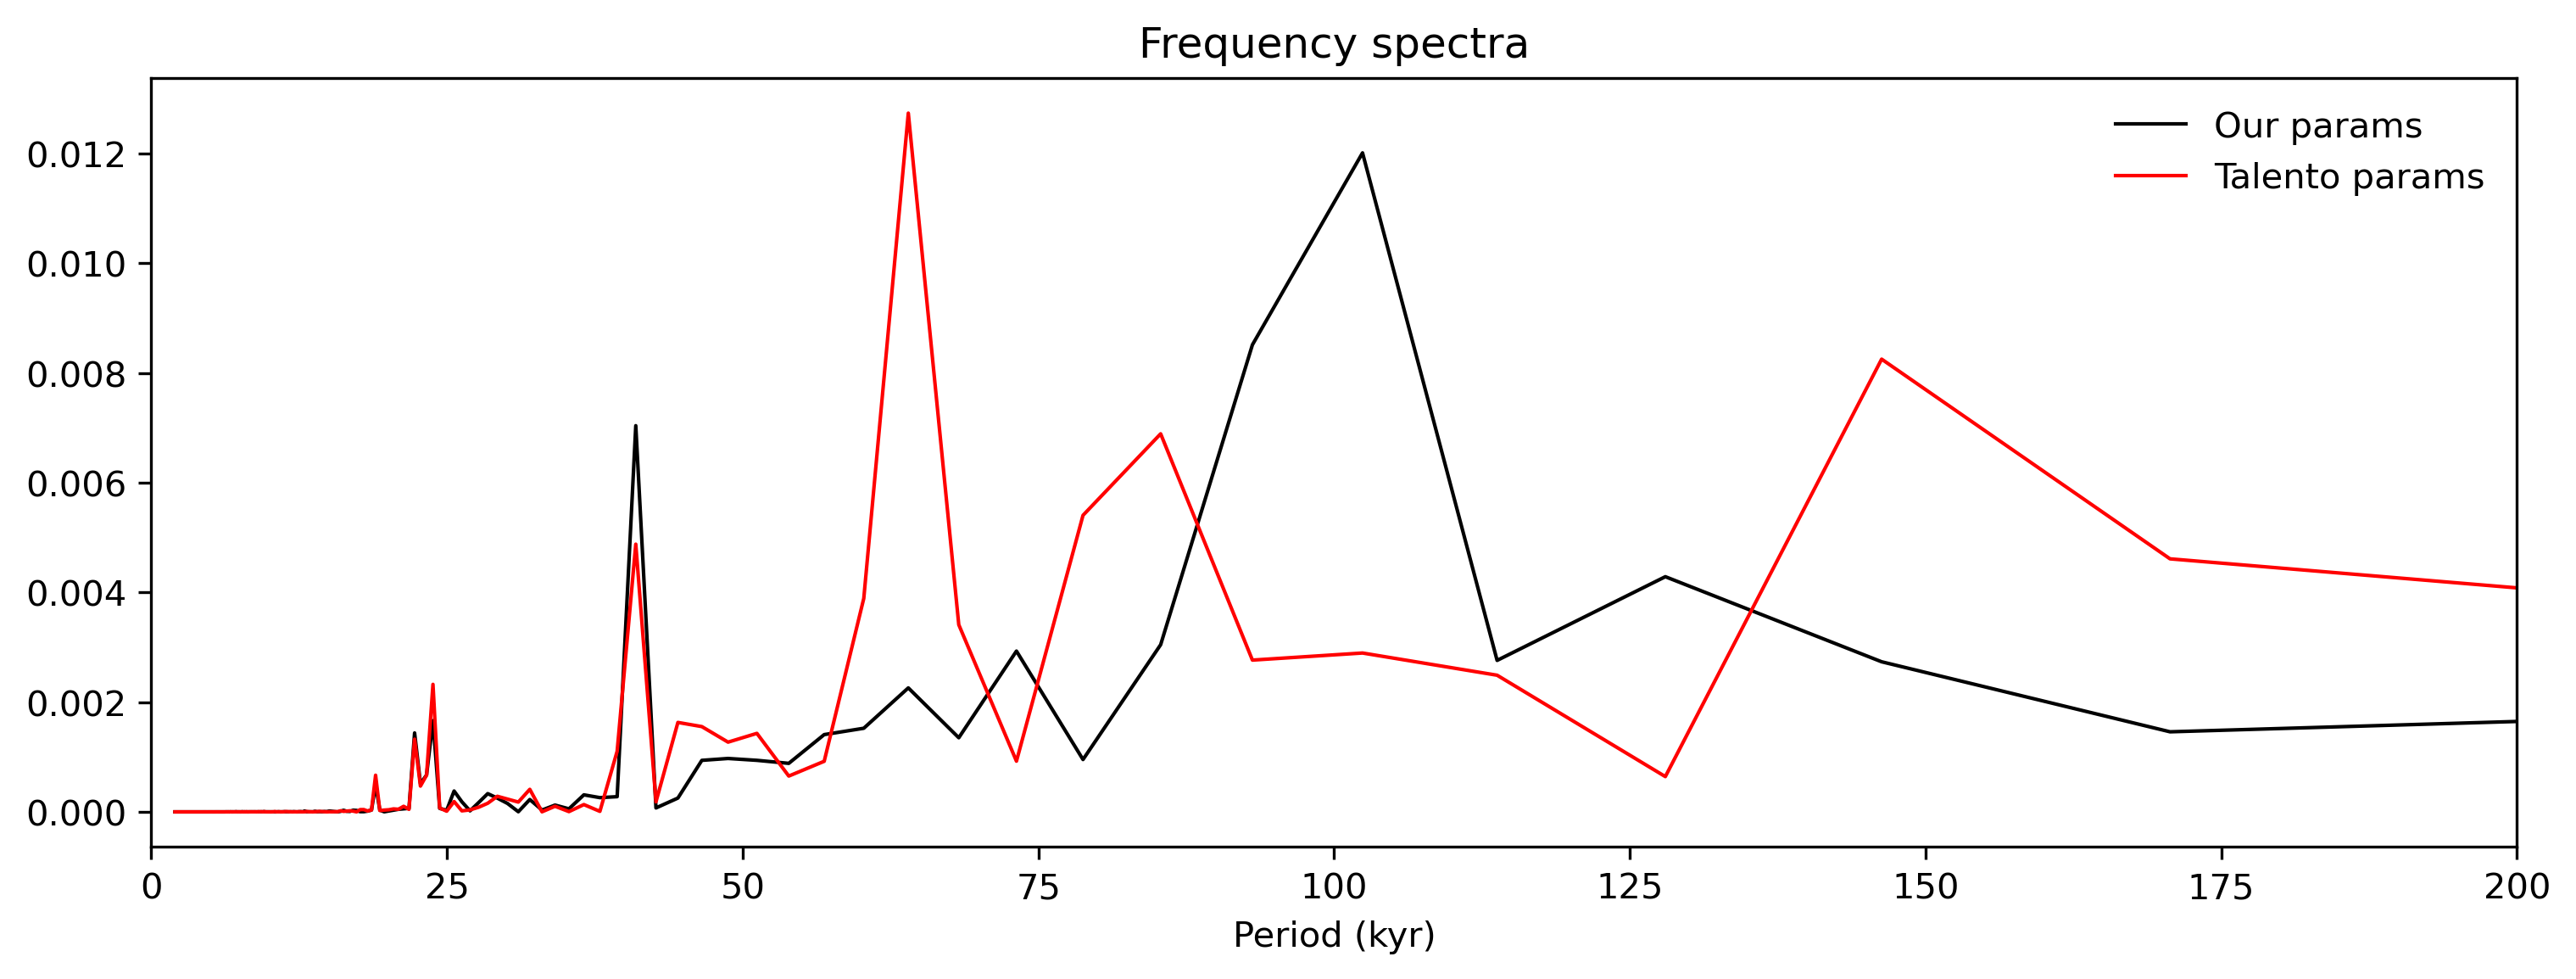

In [5]:
def frequency_spectra(x):
    T = 1       # Sampling period (kyr)
    Fs = 1 / T  # Sampling frequency (1 every 1000 yr.)
    L = len(x)  # Length of signal

    # FFT
    n = 2 ** int(np.ceil(np.log2(L)))  # this is to improve the FFT algorithm, complete with zeros until the next power of 2
    Y = np.fft.fft(x, n)
    P2 = np.abs(Y / n) ** 2
    P1 = P2[:n // 2 + 1]
    P1[1:-1] = 2 * P1[1:-1]
    ff = np.linspace(0, Fs / 2, n // 2 + 1)[:-1]          # remove last element to match MATLAB's implementation
    with np.errstate(divide='ignore', invalid='ignore'):  # ignore divide by zero warnings
        aux = 1 / ff  # Period (kyr)

    P1 = P1[:-1]
    range_ = aux

    return range_, P1

fig, ax = plt.subplots(figsize=(12, 4))
range_, P1 = frequency_spectra(m.v)
ax.plot(range_, P1, "k", lw=1, label="Our params")
ax.set_xlim(0, 200)

range_, P1 = frequency_spectra(m_talento.v)
ax.plot(range_, P1, "r", lw=1, label="Talento params")
ax.legend(framealpha=0)
ax.set_title("Frequency spectra")
ax.set_xlabel("Period (kyr)");

# Compare with palaeo-record

Palaeo data used in Talento & Ganopolski (2021) available at https://osf.io/kb76g/.

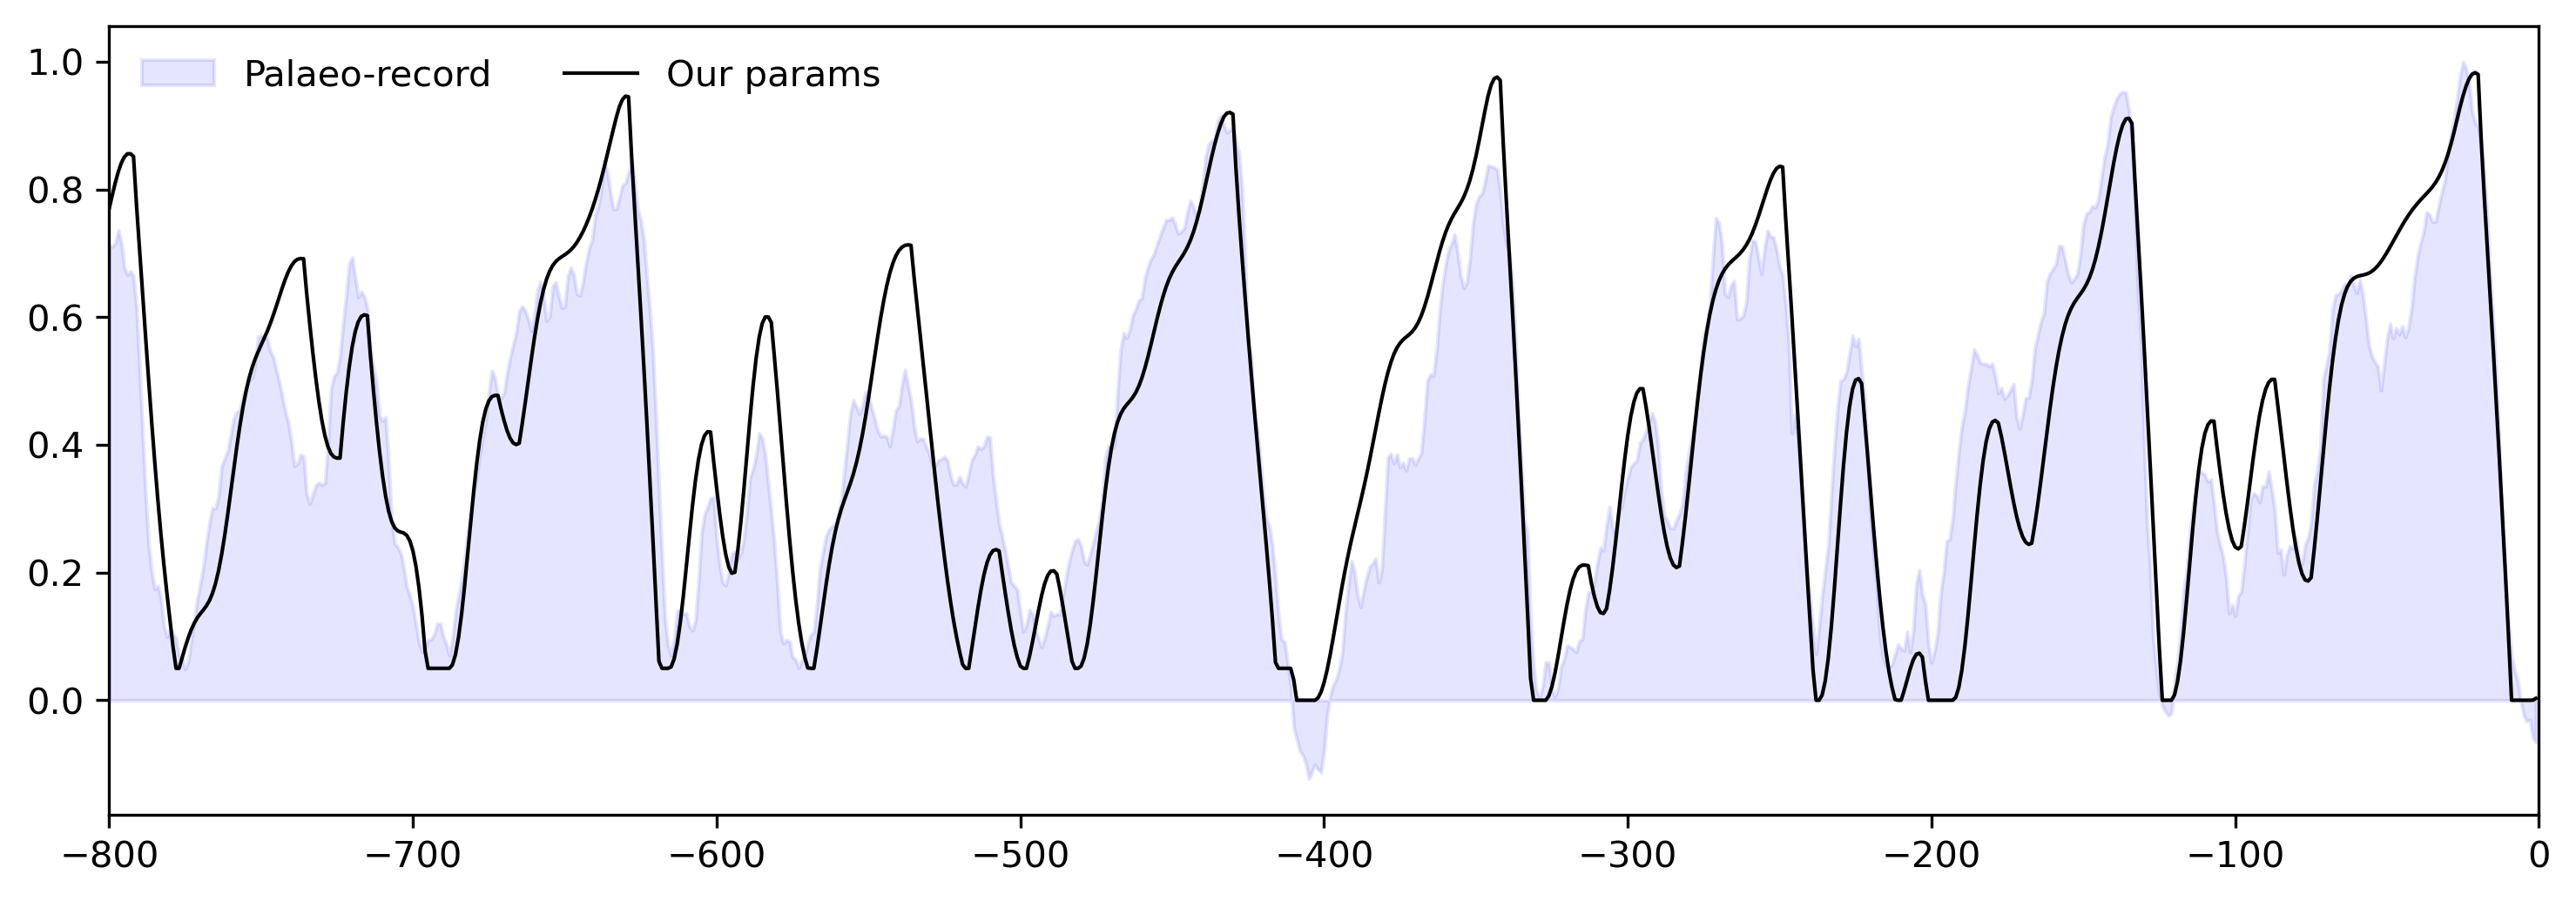

In [6]:
s = loadmat('s.mat')["s"][0]        # Load sea-level stack
paleo_v = -s                        # Invert and normalise to ice-volume proxy
paleo_v = paleo_v / np.max(paleo_v)

fig, ax = plt.subplots(figsize=(12, 4))
t = np.arange(-800, 0)
ax.fill_between(t, paleo_v, color="blue", alpha=0.1, label="Palaeo-record")
ax.plot(m.t_range, m.v, "k", lw=1, label="Our params")
ax.set_xlim(-800, 0)
ax.legend(loc="upper left", framealpha=0, ncol=2)

In [7]:
print(f"Our params correlation:", np.corrcoef(m.v[200:], paleo_v)[0, 1])
print(f"Talento params correlation:", np.corrcoef(m_talento.v[200:], paleo_v)[0, 1])

Our params correlation: 0.892050948850612
Talento params correlation: 0.46430230293314195


## With noise

In [8]:
seeds = np.arange(100)
M = [Talento(our_par, noise=0.001, seed=seeds[i]).run() for i in range(len(seeds))]

Text(0.5, 1.0, 'Stochastic ice volume trajectories')

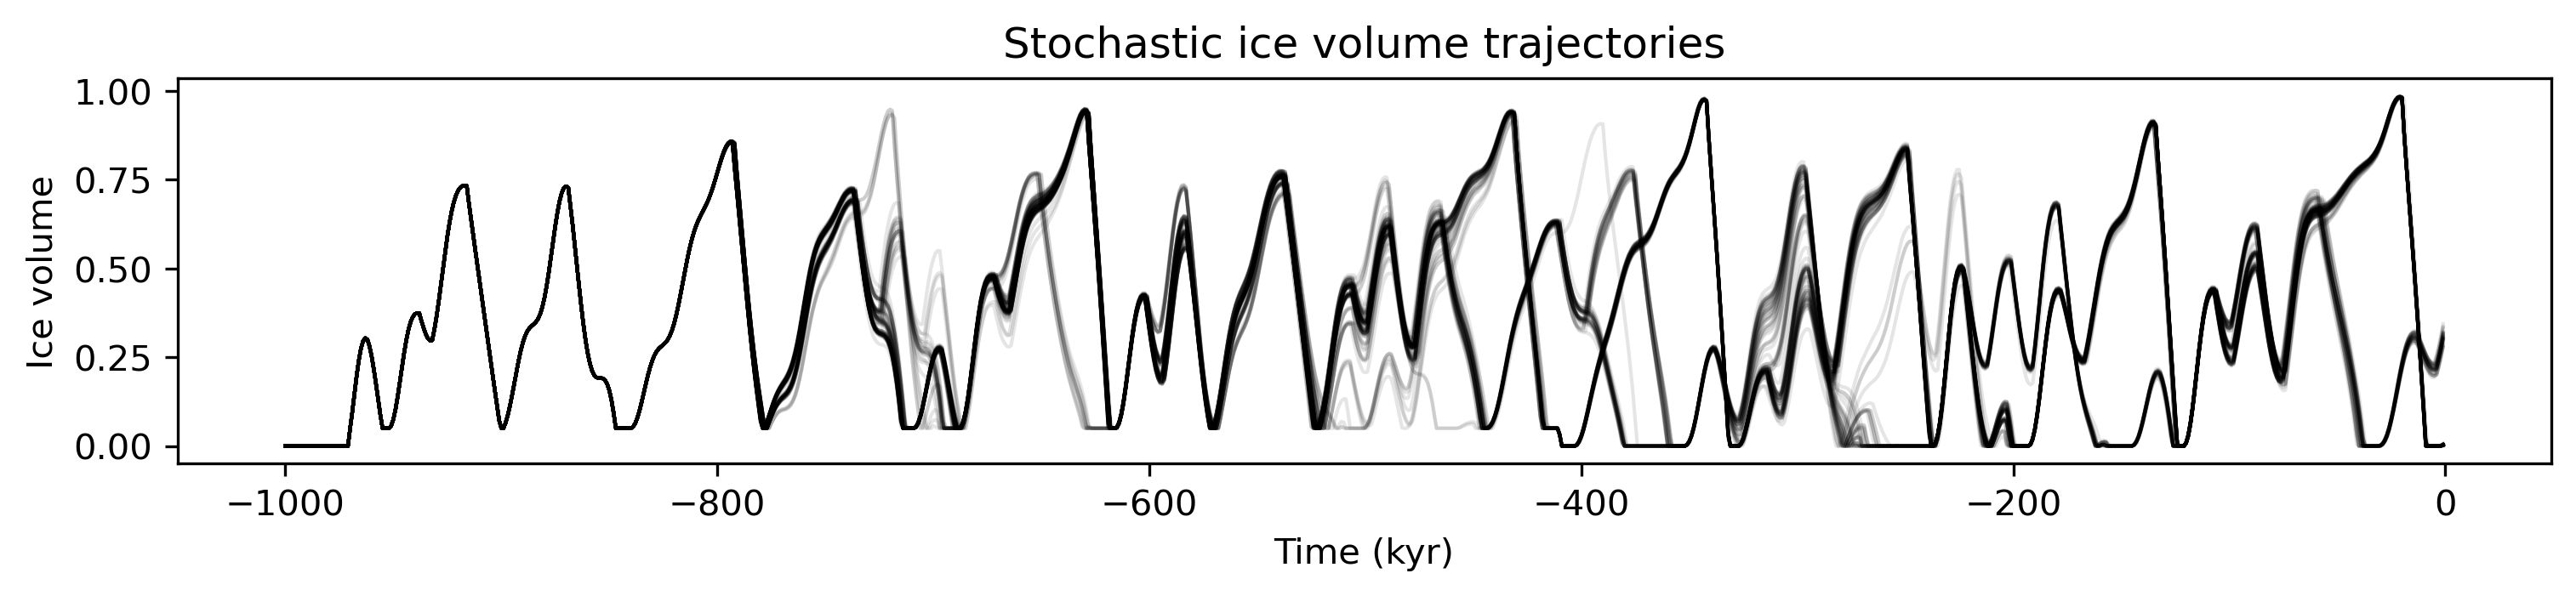

In [9]:
fig, ax = plt.subplots(figsize=(12, 2))
for m_noise in M:
    ax.plot(m_noise.t_range, m_noise.v, "k", lw=1, alpha=0.1)
ax.set_ylabel("Ice volume")
ax.set_xlabel("Time (kyr)")
ax.set_title("Stochastic ice volume trajectories")